In [101]:
# Import dataset

import pandas as pd

df_all_agg = pd.read_csv("df_all_agg.csv", sep = ',')
df_all_agg.head(1)

,Counter Name,Date,Arrondisement,Daily Count
0,10 avenue de la Grande Armée SE-NO,2023-09-01,17,731


In [75]:
!pip install hdbscan

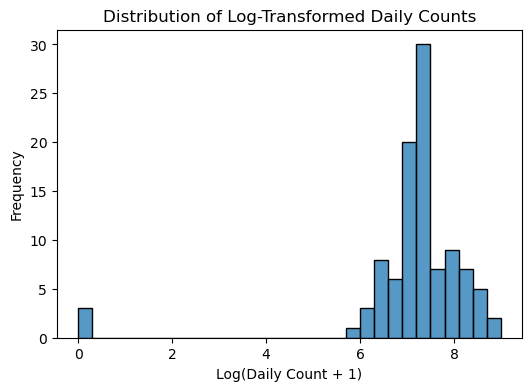

Silhouette Score: 0.6017039676440947

Points per cluster:
Cluster
 1    48
-1    46
 0     7
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_45824\1842611032.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(label)


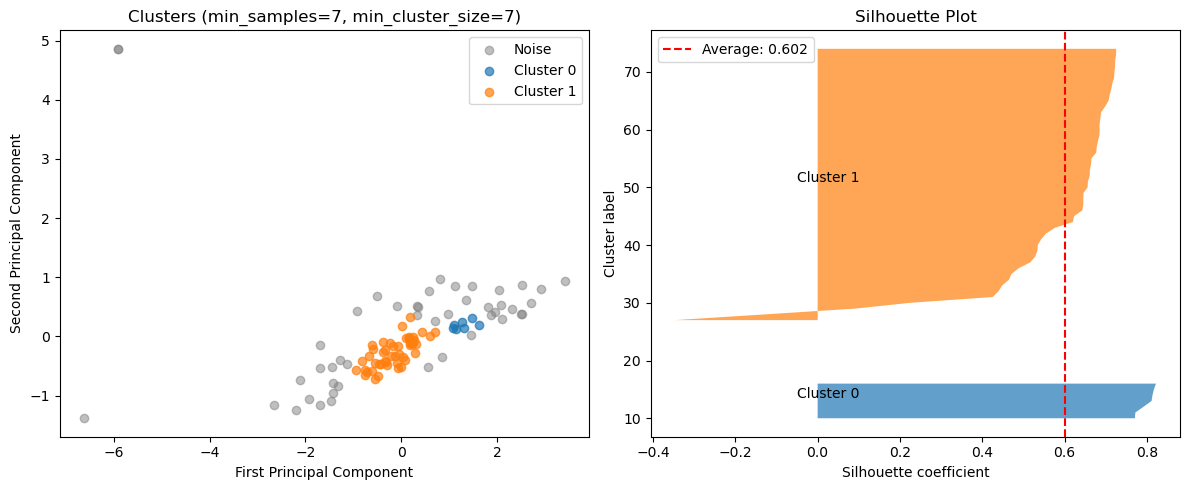

In [105]:
# HDBSCAN with log-transformed data + weekend/weekday features, and min_samples=7 and min_cluster_size=7

import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler

def prepare_data_for_clustering_with_log_plus_graph(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': 'mean',  # Overall mean
    }).reset_index()
    
    # Add weekend/weekday means
    weekend_means = df[df['Date'].dt.weekday >= 5].groupby('Counter Name')['Daily Count'].mean()
    weekday_means = df[df['Date'].dt.weekday < 5].groupby('Counter Name')['Daily Count'].mean()
    
    features['Weekend_Mean'] = features['Counter Name'].map(weekend_means)
    features['Weekday_Mean'] = features['Counter Name'].map(weekday_means)
    features['Count_Std'] = df.groupby('Counter Name')['Daily Count'].std().values
    
    # Create histogram of log-transformed daily counts
    plt.figure(figsize=(6, 4))
    sns.histplot(data=np.log1p(features['Daily Count']), bins=30)
    plt.title('Distribution of Log-Transformed Daily Counts')
    plt.xlabel('Log(Daily Count + 1)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Log transform the numeric columns
    features['Daily Count'] = np.log1p(features['Daily Count'])
    features['Weekend_Mean'] = np.log1p(features['Weekend_Mean'])
    features['Weekday_Mean'] = np.log1p(features['Weekday_Mean'])
    features['Count_Std'] = np.log1p(features['Count_Std'])
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[['Daily Count', 'Weekend_Mean', 'Weekday_Mean', 'Count_Std']])
    
    return features, features_scaled

# Apply HDBSCAN with the new features
def apply_hdbscan_and_analyze(features, features_scaled, min_samples=7, min_cluster_size=7):
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    # Add results to features df
    results = features.copy()
    results['Cluster'] = cluster_labels
    results['Cluster_Probability'] = clusterer.probabilities_
    
    # Convert back from log scale for interpretation
    results['Daily Count'] = np.exp(results['Daily Count']) - 1
    results['Weekend_Mean'] = np.exp(results['Weekend_Mean']) - 1
    results['Weekday_Mean'] = np.exp(results['Weekday_Mean']) - 1
    results['Count_Std'] = np.exp(results['Count_Std']) - 1
    
    return results, clusterer

# Run analysis
features, features_scaled = prepare_data_for_clustering_with_log_plus_graph(df_all_agg)
results, clusterer = apply_hdbscan_and_analyze(features, features_scaled)

# Calculate silhouette score
from sklearn.metrics import silhouette_score
mask = results['Cluster'] != -1
if len(set(results[mask]['Cluster'])) > 1: 
    silhouette_avg = silhouette_score(features_scaled[mask], results[mask]['Cluster'])
    print(f"Silhouette Score: {silhouette_avg}")

# Print results
print("\nPoints per cluster:")
print(results['Cluster'].value_counts())

# Show scatter and silhouette plots
clusterer = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=7)
labels = clusterer.fit_predict(features_scaled)
plot_clustering_results(features_scaled, labels, 7, 7)

In [107]:
from sklearn.metrics import silhouette_score

def prepare_data_for_clustering_with_log(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': 'mean',  # Overall mean
    }).reset_index()
    
    # Add weekend/weekday means
    weekend_means = df[df['Date'].dt.weekday >= 5].groupby('Counter Name')['Daily Count'].mean()
    weekday_means = df[df['Date'].dt.weekday < 5].groupby('Counter Name')['Daily Count'].mean()
    
    features['Weekend_Mean'] = features['Counter Name'].map(weekend_means)
    features['Weekday_Mean'] = features['Counter Name'].map(weekday_means)
    features['Count_Std'] = df.groupby('Counter Name')['Daily Count'].std().values
    
    # Log transform columns
    features['Daily Count'] = np.log1p(features['Daily Count'])
    features['Weekend_Mean'] = np.log1p(features['Weekend_Mean'])
    features['Weekday_Mean'] = np.log1p(features['Weekday_Mean'])
    features['Count_Std'] = np.log1p(features['Count_Std'])
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[['Daily Count', 'Weekend_Mean', 'Weekday_Mean', 'Count_Std']])
    
    return features, features_scaled

    

def try_parameters(features_scaled, min_samples_list=[3, 5, 7, 10], min_cluster_sizes=[3, 5, 7, 10]):
    results = []
    
    for min_samples in min_samples_list:
        for min_cluster_size in min_cluster_sizes:
            # Skip invalid combinations
            if min_cluster_size < min_samples:
                continue
                
            clusterer = hdbscan.HDBSCAN(
                min_samples=min_samples,
                min_cluster_size=min_cluster_size
            )
            
            cluster_labels = clusterer.fit_predict(features_scaled)
            
            # Only calculate silhouette if we have more than one cluster and non-noise points
            mask = cluster_labels != -1
            n_clusters = len(set(cluster_labels[mask]))
            
            if n_clusters > 1 and sum(mask) > 1:
                sil_score = silhouette_score(features_scaled[mask], cluster_labels[mask])
            else:
                sil_score = np.nan
                
            results.append({
                'min_samples': min_samples,
                'min_cluster_size': min_cluster_size,
                'n_clusters': n_clusters,
                'n_noise': sum(cluster_labels == -1),
                'silhouette': sil_score,
                'n_clustered': sum(mask)  # Number of points in clusters (not noise)
            })
    
    return pd.DataFrame(results)

# Run parameter search
features, features_scaled = prepare_data_for_clustering_with_log(df_all_agg)
results_df = try_parameters(features_scaled, 
                          min_samples_list=[3, 4, 5, 6, 7, 8, 9, 10],
                          min_cluster_sizes=[3, 4, 5, 6, 7, 8, 9, 10])

# Sort by different metrics
print("\nTop 5 parameter combinations by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False).head().to_string())

print("\nTop 5 parameter combinations by number of clustered points (fewer noise points):")
print(results_df.sort_values(['n_clustered', 'silhouette'], ascending=[False, False]).head().to_string())


Top 5 parameter combinations by silhouette score:
    min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
35           10                10           2       78    0.669570           23
25            6                10           2       42    0.655723           59
23            6                 8           2       42    0.655723           59
21            6                 6           2       42    0.655723           59
24            6                 9           2       42    0.655723           59

Top 5 parameter combinations by number of clustered points (fewer noise points):
    min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
7             3                10           2       31    0.627100           70
8             4                 4           2       37    0.629912           64
9             4                 5           2       37    0.629912           64
10            4                 6           2       37    0.629912 

In [109]:
### Try with the best combo from above, 3 and 10


# Run the analysis
features, features_scaled = prepare_data_for_clustering_with_log(df_all_agg)
results, clusterer = apply_hdbscan_and_analyze(features, features_scaled)

# Calculate silhouette score
from sklearn.metrics import silhouette_score
mask = results['Cluster'] != -1
if len(set(results[mask]['Cluster'])) > 1:  # Need at least 2 clusters
    silhouette_avg = silhouette_score(features_scaled[mask], results[mask]['Cluster'])
    print(f"Silhouette Score: {silhouette_avg}")

# Print results
print("\nClustering Results:")
print("\nPoints per cluster:")
print(results['Cluster'].value_counts())


  


Silhouette Score: 0.6017039676440947

Clustering Results:

Points per cluster:
Cluster
 1    48
-1    46
 0     7
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_45824\381806782.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(label)


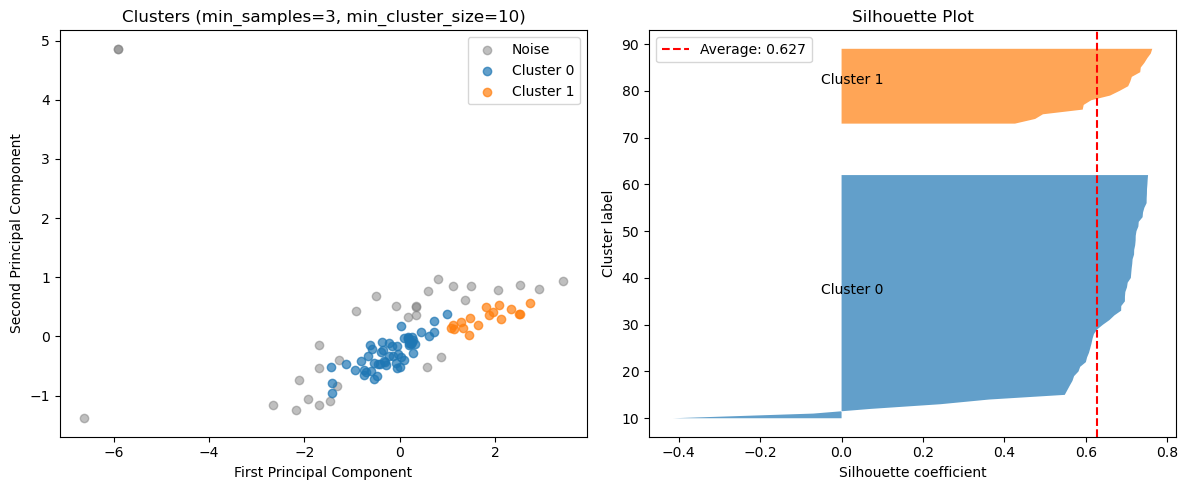


Points per cluster:
Cluster -1: 31 points
Cluster 0: 53 points
Cluster 1: 17 points


In [115]:
# Make scatterplot and silhouette plot

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

def prepare_data_with_multiple_features(df):
    # Convert Date to datetime if not already
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': [
            ('Overall_Mean', 'mean'),  # mean of daily counts
            ('Overall_Std', 'std'),    # std of daily counts
            ('Weekend_Mean', lambda x: x[df['Date'].dt.weekday >= 5].mean()),
            ('Weekday_Mean', lambda x: x[df['Date'].dt.weekday < 5].mean())
        ]
    }).reset_index()
    
    # Flatten column names
    features.columns = ['Counter_Name'] + [col[1] for col in features.columns[1:]]
    
       # Log transform all numeric columns
    numeric_columns = ['Overall_Mean', 'Overall_Std', 'Weekend_Mean', 'Weekday_Mean']
    for col in numeric_columns:
        features[col] = np.log1p(features[col])

 # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[numeric_columns])
    
    return features, features_scaled, numeric_columns  # Now also returning column names

def plot_clustering_results(features_scaled, cluster_labels, min_samples=3, min_cluster_size=10):
    # Handle NaN values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    features_clean = imputer.fit_transform(features_scaled)
    
    # First, reduce dimensions to 2D for visualization using PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_clean)
    
    # Create scatter plot
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Cluster scatter plot
    plt.subplot(121)
    
    # Plot noise points first
    noise_mask = cluster_labels == -1
    plt.scatter(features_2d[noise_mask, 0], features_2d[noise_mask, 1], 
                c='gray', label='Noise', alpha=0.5)
    
    # Plot clusters
    for label in set(cluster_labels[cluster_labels != -1]):
        mask = cluster_labels == label
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   label=f'Cluster {label}', alpha=0.7)
    
    plt.title(f'Clusters (min_samples={min_samples}, min_cluster_size={min_cluster_size})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    
    # Subplot 2: Silhouette plot
    plt.subplot(122)
    
    # Calculate silhouette scores for non-noise points
    non_noise_mask = cluster_labels != -1
    if sum(non_noise_mask) > 1 and len(set(cluster_labels[non_noise_mask])) > 1:
        silhouette_vals = silhouette_samples(features_clean[non_noise_mask], 
                                           cluster_labels[non_noise_mask])
        
        y_lower = 10
        for label in sorted(set(cluster_labels[cluster_labels != -1])):
            cluster_silhouette_vals = silhouette_vals[cluster_labels[non_noise_mask] == label]
            cluster_silhouette_vals.sort()
            
            size_cluster = len(cluster_silhouette_vals)
            y_upper = y_lower + size_cluster
            
            color = plt.cm.get_cmap('tab10')(label)
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                             facecolor=color, alpha=0.7)
            
            plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {label}')
            y_lower = y_upper + 10
            
        plt.title('Silhouette Plot')
        plt.xlabel('Silhouette coefficient')
        plt.ylabel('Cluster label')
        plt.axvline(x=silhouette_vals.mean(), color='red', linestyle='--', 
                    label=f'Average: {silhouette_vals.mean():.3f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Get features
features, features_scaled, _ = prepare_data_with_multiple_features(df_all_agg)

# Try with desired parameters
clusterer = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=10)
labels = clusterer.fit_predict(features_scaled)
plot_clustering_results(features_scaled, labels, 3, 10)

# Print cluster sizes
unique_labels, counts = np.unique(labels, return_counts=True)
print("\nPoints per cluster:")
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} points")
  


In [117]:
# Determine PCA loadings

def prepare_data_with_multiple_features(df):
    # Convert Date to datetime if not already
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': [
            ('Overall_Mean', 'mean'),  # mean of daily counts
            ('Overall_Std', 'std'),    # std of daily counts
            ('Weekend_Mean', lambda x: x[df['Date'].dt.weekday >= 5].mean()),
            ('Weekday_Mean', lambda x: x[df['Date'].dt.weekday < 5].mean())
        ]
    }).reset_index()
    
    # Flatten column names
    features.columns = ['Counter_Name'] + [col[1] for col in features.columns[1:]]
    
    # Log transform all numeric columns
    numeric_columns = ['Overall_Mean', 'Overall_Std', 'Weekend_Mean', 'Weekday_Mean']
    for col in numeric_columns:
        features[col] = np.log1p(features[col])

 # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[numeric_columns])
    
    return features, features_scaled, numeric_columns  # Now also returning column names

# Get features and column names
features, features_scaled, feature_names = prepare_data_with_multiple_features(df_all_agg)
imputer = SimpleImputer(strategy='mean')
features_clean = imputer.fit_transform(features_scaled)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(features_clean)

# Create a dataframe of the feature loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['First Principal Component', 'Second Principal Component'],
    index=feature_names
)

print("PCA Loadings (how much each feature contributes to each component):")
print(loadings)

print("\nVariance explained by each component:")
print(f"First Principal Component: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Second Principal Component: {pca.explained_variance_ratio_[1]:.3f}")
    

PCA Loadings (how much each feature contributes to each component):
              First Principal Component  Second Principal Component
Overall_Mean                   0.569745                   -0.373713
Overall_Std                    0.418953                    0.644949
Weekend_Mean                   0.517854                   -0.509825
Weekday_Mean                   0.481349                    0.429486

Variance explained by each component:
First Principal Component: 0.662
Second Principal Component: 0.191


In [ ]:
##### Now new HDBSCAN with seasonality features #####
### NOT USED IN REPORT ###

In [53]:
# Test different parameter combinations

import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler

def prepare_data_with_multiple_features(df):
    # Convert Date to datetime if not already
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Add season
    df['Season'] = pd.cut(df['Date'].dt.month, 
                         bins=[0,3,6,9,12], 
                         labels=['Winter','Spring','Summer','Fall'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': [
            ('Overall_Mean', 'mean'),  # mean of daily counts
            ('Overall_Std', 'std'),    # std of daily counts
            ('Weekend_Mean', lambda x: x[df['Date'].dt.weekday >= 5].mean()),
            ('Weekday_Mean', lambda x: x[df['Date'].dt.weekday < 5].mean()),
            ('Summer_Mean', lambda x: x[df['Season']=='Summer'].mean()),
            ('Spring_Mean', lambda x: x[df['Season']=='Spring'].mean()),
            ('Fall_Mean', lambda x: x[df['Season']=='Fall'].mean()),
            ('Winter_Mean', lambda x: x[df['Season']=='Winter'].mean())
        ]
    }).reset_index()
    
    # Flatten column names
    features.columns = ['Counter_Name'] + [col[1] for col in features.columns[1:]]
    
    # Log transform all numeric columns
    numeric_columns = ['Overall_Mean', 'Overall_Std', 'Weekend_Mean', 'Weekday_Mean',
                      'Summer_Mean', 'Spring_Mean', 'Fall_Mean', 'Winter_Mean']
    for col in numeric_columns:
        features[col] = np.log1p(features[col])
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[numeric_columns])
    
    return features, features_scaled, numeric_columns

# Apply HDBSCAN
def apply_hdbscan_and_analyze(features, features_scaled, min_samples=3, min_cluster_size=10):
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    # Add results to features DataFrame
    results = features.copy()
    results['Cluster'] = cluster_labels
    results['Cluster_Probability'] = clusterer.probabilities_
    
    # Convert back from log scale for interpretation
    numeric_columns = ['Overall_Mean', 'Overall_Std', 'Weekend_Mean', 'Weekday_Mean',
                      'Summer_Mean', 'Spring_Mean', 'Fall_Mean', 'Winter_Mean']
    for col in numeric_columns:
        results[col] = np.exp(results[col]) - 1
        
    return results, clusterer

# Run the analysis
features, features_scaled, feature_names = prepare_data_with_multiple_features(df_all_agg)

# Calculate silhouette score for different parameters
def try_parameters(features_scaled, min_samples_list=[3, 4, 5, 6, 7, 8, 9, 10], 
                  min_cluster_sizes=[3, 4, 5, 6, 7, 8, 9, 10]):
    results = []
    
    for min_samples in min_samples_list:
        for min_cluster_size in min_cluster_sizes:
            if min_cluster_size < min_samples:
                continue
                
            clusterer = hdbscan.HDBSCAN(
                min_samples=min_samples,
                min_cluster_size=min_cluster_size
            )
            
            cluster_labels = clusterer.fit_predict(features_scaled)
            
            mask = cluster_labels != -1
            n_clusters = len(set(cluster_labels[mask]))
            
            if n_clusters > 1 and sum(mask) > 1:
                from sklearn.metrics import silhouette_score
                sil_score = silhouette_score(features_scaled[mask], cluster_labels[mask])
            else:
                sil_score = np.nan
                
            results.append({
                'min_samples': min_samples,
                'min_cluster_size': min_cluster_size,
                'n_clusters': n_clusters,
                'n_noise': sum(cluster_labels == -1),
                'silhouette': sil_score,
                'n_clustered': sum(mask)
            })
    
    return pd.DataFrame(results)

# Try different parameters
results_df = try_parameters(features_scaled)

print("\nTop 5 parameter combinations by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False).head().to_string())

print("\nTop 5 parameter combinations by number of clustered points:")
print(results_df.sort_values(['n_clustered', 'silhouette'], ascending=[False, False]).head().to_string())


Top 5 parameter combinations by silhouette score:
    min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
4             3                 7           2       37    0.679321           64
5             3                 8           2       37    0.679321           64
6             3                 9           2       37    0.679321           64
7             3                10           2       37    0.679321           64
19            5                 9           2       38    0.644963           63

Top 5 parameter combinations by number of clustered points:
   min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
0            3                 3           3       31    0.571747           70
1            3                 4           3       31    0.571747           70
2            3                 5           3       31    0.571747           70
3            3                 6           3       31    0.571747           70
4            

In [55]:
# So ^ not better than the previous analysis

# Now will try with weekend/weekday features taken out (so just seasonality plus mean and std)

import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler

def prepare_data_with_seasonal_features(df):
    # Convert Date to datetime if not already
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Add season
    df['Season'] = pd.cut(df['Date'].dt.month, 
                         bins=[0,3,6,9,12], 
                         labels=['Winter','Spring','Summer','Fall'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': [
            ('Overall_Mean', 'mean'),  # mean of daily counts
            ('Overall_Std', 'std'),    # std of daily counts
            ('Summer_Mean', lambda x: x[df['Season']=='Summer'].mean()),
            ('Spring_Mean', lambda x: x[df['Season']=='Spring'].mean()),
            ('Fall_Mean', lambda x: x[df['Season']=='Fall'].mean()),
            ('Winter_Mean', lambda x: x[df['Season']=='Winter'].mean())
        ]
    }).reset_index()
    
    # Flatten column names
    features.columns = ['Counter_Name'] + [col[1] for col in features.columns[1:]]
    
    # Log transform all numeric columns
    numeric_columns = ['Overall_Mean', 'Overall_Std', 
                      'Summer_Mean', 'Spring_Mean', 'Fall_Mean', 'Winter_Mean']
    for col in numeric_columns:
        features[col] = np.log1p(features[col])
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[numeric_columns])
    
    return features, features_scaled, numeric_columns

# Try different parameters
def try_parameters(features_scaled, min_samples_list=[3, 4, 5, 6, 7, 8, 9, 10], 
                  min_cluster_sizes=[3, 4, 5, 6, 7, 8, 9, 10]):
    results = []
    
    for min_samples in min_samples_list:
        for min_cluster_size in min_cluster_sizes:
            if min_cluster_size < min_samples:
                continue
                
            clusterer = hdbscan.HDBSCAN(
                min_samples=min_samples,
                min_cluster_size=min_cluster_size
            )
            
            cluster_labels = clusterer.fit_predict(features_scaled)
            
            mask = cluster_labels != -1
            n_clusters = len(set(cluster_labels[mask]))
            
            if n_clusters > 1 and sum(mask) > 1:
                from sklearn.metrics import silhouette_score
                sil_score = silhouette_score(features_scaled[mask], cluster_labels[mask])
            else:
                sil_score = np.nan
                
            results.append({
                'min_samples': min_samples,
                'min_cluster_size': min_cluster_size,
                'n_clusters': n_clusters,
                'n_noise': sum(cluster_labels == -1),
                'silhouette': sil_score,
                'n_clustered': sum(mask)
            })
    
    return pd.DataFrame(results)

# Run the analysis
features, features_scaled, feature_names = prepare_data_with_seasonal_features(df_all_agg)
results_df = try_parameters(features_scaled)

print("\nTop 5 parameter combinations by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False).head().to_string())

print("\nTop 5 parameter combinations by number of clustered points:")
print(results_df.sort_values(['n_clustered', 'silhouette'], ascending=[False, False]).head().to_string())



Top 5 parameter combinations by silhouette score:
    min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
6             3                 9           2       39    0.670811           62
7             3                10           2       39    0.670811           62
18            5                 8           2       46    0.664893           55
17            5                 7           2       46    0.664893           55
16            5                 6           2       46    0.664893           55

Top 5 parameter combinations by number of clustered points:
   min_samples  min_cluster_size  n_clusters  n_noise  silhouette  n_clustered
2            3                 5           3       31    0.582857           70
3            3                 6           3       31    0.582857           70
4            3                 7           3       31    0.582857           70
5            3                 8           3       31    0.582857           70
0            